In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
import sys
import function as func

In [2]:
# Constants
v_c = 220.e+3 # [m/sec] speed of solar system
v_E = v_c # [m/sec] speed of earth
c = 299792458. # [m/sec] speed of light from wikipedia
k_B = 1.380649e-23 # [J/K] boltzmann constant
rbw = 3.e+2 # [Hz]
binwidth = 2.e+3 # [Hz]
TLN2 = 77 # [K]

In [7]:
if __name__ == "__main__":
    """
    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
    for p in check_freq:
        start_freq = p/10
        #print(start_freq)
        
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)
    """

    yfactor = func.csv_to_array("/data/ms2840a/result_data/check_result/yfactor_check_result.csv")

    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])

    for i in check_freq:
        word = list(str(i*1000 - 250))
        word.insert(2, ".")
        start = "".join(word)
        print(start)

        Gain = 0
        Trx = 0
        Gain_err = 0
        Trx_err = 0
        for _f, freq in enumerate(yfactor["freq"]):
            if float(freq) * 1e+6 == float(start) * 1e+6:
                Gain = yfactor["Gain"][_f]
                Trx = yfactor["Trx"][_f]
                Gain_err = yfactor["Gain_err"][_f]
                Trx_err = yfactor["Trx_err"][_f]
                break

        W_twelve = []
        freq = np.array([])
        for j in range(12):
            path = "/data/ms2840a/signal_data_check/2022-01-17/data/scan_FFT_" + start + "GHz_span2.50MHz_rbw0.3kHz_20.0sec_1counts_12runs_" + str(j) + ".dat"
            freq, W = func.dat_to_array(path)
            W_twelve.append(W/Gain - k_B*Trx*rbw)
        
        column = ["freq"] + ["W_{}".format(str(x)) for x in range(12)]
        '''
        with open("/data/ms2840a/result_data/check_result/signal_12_data/start_{}GHz.csv".format(start), "w") as f:
            writer = csv.writer(f)
            writer.writerow(column)
            for j in range(len(freq)):
                writer.writerow([freq[j]] + [W_twelve[x][j] for x in range(12)])
        '''

18.189750
18.335750
19.119750
19.185750
19.439750
19.477750
19.765750
19.793750
19.817750
20.005750
20.295750
20.301750
20.489750
20.539750
20.891750
21.441750
21.807750
22.521750
22.671750
23.305750
23.807750
23.933750
25.327750
25.351750
25.859750
26.273750
26.345750


# Get original signal ($P_\mathrm{in}$) (NEW IMPLEMENTATION)

In [3]:
def get_original_signal(start, yfactor, in_datadir, out_datadir, Pin_rbw, doRebin=False, rebinmethod=0, time_str='2.0'):
    Gain = 0
    Trx = 0
    Gain_err = 0
    Trx_err = 0
    for _f, freq in enumerate(yfactor["freq"]):
        if float(freq) * 1e+6 == float(start) * 1e+6:
            Gain = yfactor["Gain"][_f]
            Trx = yfactor["Trx"][_f]
            Gain_err = yfactor["Gain_err"][_f]
            Trx_err = yfactor["Trx_err"][_f]
            break

    W_twelve = []
    freq = np.array([])
    for j in range(12):
        path = f"{in_datadir}/scan_FFT_{start}GHz_span2.50MHz_rbw0.3kHz_{time_str}sec_1counts_12runs_{j}.dat"
        freq, W, tmp = func.dat_to_array(path, doRebin=doRebin, rebinmethod=rebinmethod)
        W_twelve.append(W/Gain - k_B*Trx*Pin_rbw)
        pass
    
    column = ["freq"] + ["W_{}".format(str(x)) for x in range(12)]
    outdir2 = f'{out_datadir}/signal_12_data'
    if not os.path.isdir(outdir2):
        os.makedirs(outdir2)
        pass
    with open(f"{outdir2}/start_{start}GHz.csv", "w") as f:
        writer = csv.writer(f)
        writer.writerow(column)
        for j in range(len(freq)):
            writer.writerow([freq[j]] + [W_twelve[x][j] for x in range(12)])
            pass
        pass # End of opening output file
    
    return
        
def loop_get_original_signal_normaldata(
    in_yfactor="/data/ms2840a/result_data/yfactor_result_rebin2MHz.csv", 
    in_datadir="/data/ms2840a/signal_raw_data",
    out_datadir = "/data/ms2840a/result_data/",
    Pin_rbw = 300.,
    doRebin = False,
    rebinmethod = 0,
    verbose=1):
    
    yfactor = func.csv_to_array(in_yfactor)
    check_freq = func.check_freq

    
    # start frequencies with 100MHz steps
    for i in range(180, 265, 1):
        if i%10 == 0: print(f'freq = {i*0.1} GHz')
        start_freq = i/10
        initial = int(start_freq * 1.e+6 - 250)
        final = int(initial + 1.e+5)
        
        for j in range(initial, final, 2000):
            word = list(str(j))
            word.insert(2, ".")
            start = "".join(word)
            start_Hz = (float)(start)*1e+9
            print(start, start_Hz)
            get_original_signal(start=start, yfactor=yfactor, in_datadir=in_datadir, 
                                out_datadir=out_datadir, Pin_rbw=Pin_rbw, doRebin=doRebin, 
                                rebinmethod=rebinmethod, time_str='2.0')
            pass # End of loop over 2MHz steps
        
        pass # End of loop over 100MHz steps
    
    return
    
def loop_get_original_signal_checkdata(
    in_yfactor="/data/ms2840a/result_data/check_result/yfactor_check_result.csv", 
    in_datadir="/data/ms2840a/signal_data_check/2022-01-17/data",
    out_datadir = "/data/ms2840a/result_data/check_result",
    Pin_rbw = 300.,
    doRebin = False,
    rebinmethod = 0,
    verbose=1):
    
    yfactor = func.csv_to_array(in_yfactor)
    check_freq = func.check_freq

    for i in check_freq:
        word = list(str(i*1000 - 250))
        word.insert(2, ".")
        start = "".join(word)
        if verbose > 0: print(start)

        get_original_signal(start=start, yfactor=yfactor, in_datadir=in_datadir, 
                            out_datadir=out_datadir, Pin_rbw=Pin_rbw, doRebin=doRebin, 
                            rebinmethod=rebinmethod, time_str='20.0')
        pass # End of loop over check freqs
    
    return

## Old Implementation (No rebin)

In [33]:
## Old implementation
'''
loop_get_original_signal_normaldata(
    in_yfactor="/data/ms2840a/result_data/yfactor_result_rebin2MHz.csv", 
    in_datadir="/data/ms2840a/signal_raw_data",
    out_datadir = "/data/ms2840a/result_data/",
    Pin_rbw = 300., doRebin=False)
loop_get_original_signal_checkdata(
    in_yfactor="/data/ms2840a/result_data/check_result/yfactor_check_result.csv", 
    in_datadir="/data/ms2840a/signal_data_check/2022-01-17/data",
    out_datadir = "/data/ms2840a/result_data/check_result",
    Pin_rbw = 300., doRebin=False)
'''

'\nloop_get_original_signal_normaldata(\n    in_yfactor="/data/ms2840a/result_data/yfactor_result_rebin2MHz.csv", \n    in_datadir="/data/ms2840a/signal_raw_data",\n    out_datadir = "/data/ms2840a/result_data/",\n    Pin_rbw = 300., doRebin=False)\nloop_get_original_signal_checkdata(\n    in_yfactor="/data/ms2840a/result_data/check_result/yfactor_check_result.csv", \n    in_datadir="/data/ms2840a/signal_data_check/2022-01-17/data",\n    out_datadir = "/data/ms2840a/result_data/check_result",\n    Pin_rbw = 300., doRebin=False)\n'

## New implementation with rebinned raw data (rebinmethod=0)

In [4]:
## New implementation with rebinned raw data 
RBW=2.e+3
new_datadir = './output/result_data_newrebin'
rebinmethod = 0

In [6]:
loop_get_original_signal_normaldata(
    in_yfactor=f"{new_datadir}/yfactor_result_rebin2MHz.csv", 
    in_datadir="/data/ms2840a/signal_raw_data",
    out_datadir = f"{new_datadir}/",
    Pin_rbw = RBW, doRebin=True, rebinmethod=rebinmethod)

freq = 18.0 GHz
17.999750 17999750000.0
18.001750 18001750000.0
18.003750 18003750000.0
18.005750 18005750000.0
18.007750 18007750000.0
18.009750 18009750000.0
18.011750 18011750000.0
18.013750 18013750000.0
18.015750 18015750000.0
18.017750 18017750000.0
18.019750 18019750000.0
18.021750 18021750000.0
18.023750 18023750000.0
18.025750 18025750000.0
18.027750 18027750000.0
18.029750 18029750000.0
18.031750 18031750000.0
18.033750 18033750000.0
18.035750 18035750000.0
18.037750 18037750000.0
18.039750 18039750000.0
18.041750 18041750000.0
18.043750 18043750000.0
18.045750 18045750000.0
18.047750 18047750000.0
18.049750 18049750000.0
18.051750 18051750000.0
18.053750 18053750000.0
18.055750 18055750000.0
18.057750 18057750000.0
18.059750 18059750000.0
18.061750 18061750000.0
18.063750 18063750000.0
18.065750 18065750000.0
18.067750 18067750000.0
18.069750 18069750000.0
18.071750 18071750000.0
18.073750 18073750000.0
18.075750 18075750000.0
18.077750 18077750000.0
18.079750 18079750000.0


18.681750 18681750000.0
18.683750 18683750000.0
18.685750 18685750000.0
18.687750 18687750000.0
18.689750 18689750000.0
18.691750 18691750000.0
18.693750 18693750000.0
18.695750 18695750000.0
18.697750 18697750000.0
18.699750 18699750000.0
18.701750 18701750000.0
18.703750 18703750000.0
18.705750 18705750000.0
18.707750 18707750000.0
18.709750 18709750000.0
18.711750 18711750000.0
18.713750 18713750000.0
18.715750 18715750000.0
18.717750 18717750000.0
18.719750 18719750000.0
18.721750 18721750000.0
18.723750 18723750000.0
18.725750 18725750000.0
18.727750 18727750000.0
18.729750 18729750000.0
18.731750 18731750000.0
18.733750 18733750000.0
18.735750 18735750000.0
18.737750 18737750000.0
18.739750 18739750000.0
18.741750 18741750000.0
18.743750 18743750000.0
18.745750 18745750000.0
18.747750 18747750000.0
18.749750 18749750000.0
18.751750 18751750000.0
18.753750 18753750000.0
18.755750 18755750000.0
18.757750 18757750000.0
18.759750 18759750000.0
18.761750 18761750000.0
18.763750 187637

19.363750 19363750000.0
19.365750 19365750000.0
19.367750 19367750000.0
19.369750 19369750000.0
19.371750 19371750000.0
19.373750 19373750000.0
19.375750 19375750000.0
19.377750 19377750000.0
19.379750 19379750000.0
19.381750 19381750000.0
19.383750 19383750000.0
19.385750 19385750000.0
19.387750 19387750000.0
19.389750 19389750000.0
19.391750 19391750000.0
19.393750 19393750000.0
19.395750 19395750000.0
19.397750 19397750000.0
19.399750 19399750000.0
19.401750 19401750000.0
19.403750 19403750000.0
19.405750 19405750000.0
19.407750 19407750000.0
19.409750 19409750000.0
19.411750 19411750000.0
19.413750 19413750000.0
19.415750 19415750000.0
19.417750 19417750000.0
19.419750 19419750000.0
19.421750 19421750000.0
19.423750 19423750000.0
19.425750 19425750000.0
19.427750 19427750000.0
19.429750 19429750000.0
19.431750 19431750000.0
19.433750 19433750000.0
19.435750 19435750000.0
19.437750 19437750000.0
19.439750 19439750000.0
19.441750 19441750000.0
19.443750 19443750000.0
19.445750 194457

20.045750 20045750000.0
20.047750 20047750000.0
20.049750 20049750000.0
20.051750 20051750000.0
20.053750 20053750000.0
20.055750 20055750000.0
20.057750 20057750000.0
20.059750 20059750000.0
20.061750 20061750000.0
20.063750 20063750000.0
20.065750 20065750000.0
20.067750 20067750000.0
20.069750 20069750000.0
20.071750 20071750000.0
20.073750 20073750000.0
20.075750 20075750000.0
20.077750 20077750000.0
20.079750 20079750000.0
20.081750 20081750000.0
20.083750 20083750000.0
20.085750 20085750000.0
20.087750 20087750000.0
20.089750 20089750000.0
20.091750 20091750000.0
20.093750 20093750000.0
20.095750 20095750000.0
20.097750 20097750000.0
20.099750 20099750000.0
20.101750 20101750000.0
20.103750 20103750000.0
20.105750 20105750000.0
20.107750 20107750000.0
20.109750 20109750000.0
20.111750 20111750000.0
20.113750 20113750000.0
20.115750 20115750000.0
20.117750 20117750000.0
20.119750 20119750000.0
20.121750 20121750000.0
20.123750 20123750000.0
20.125750 20125750000.0
20.127750 201277

20.729750 20729750000.0
20.731750 20731750000.0
20.733750 20733750000.0
20.735750 20735750000.0
20.737750 20737750000.0
20.739750 20739750000.0
20.741750 20741750000.0
20.743750 20743750000.0
20.745750 20745750000.0
20.747750 20747750000.0
20.749750 20749750000.0
20.751750 20751750000.0
20.753750 20753750000.0
20.755750 20755750000.0
20.757750 20757750000.0
20.759750 20759750000.0
20.761750 20761750000.0
20.763750 20763750000.0
20.765750 20765750000.0
20.767750 20767750000.0
20.769750 20769750000.0
20.771750 20771750000.0
20.773750 20773750000.0
20.775750 20775750000.0
20.777750 20777750000.0
20.779750 20779750000.0
20.781750 20781750000.0
20.783750 20783750000.0
20.785750 20785750000.0
20.787750 20787750000.0
20.789750 20789750000.0
20.791750 20791750000.0
20.793750 20793750000.0
20.795750 20795750000.0
20.797750 20797750000.0
20.799750 20799750000.0
20.801750 20801750000.0
20.803750 20803750000.0
20.805750 20805750000.0
20.807750 20807750000.0
20.809750 20809750000.0
20.811750 208117

21.411750 21411750000.0
21.413750 21413750000.0
21.415750 21415750000.0
21.417750 21417750000.0
21.419750 21419750000.0
21.421750 21421750000.0
21.423750 21423750000.0
21.425750 21425750000.0
21.427750 21427750000.0
21.429750 21429750000.0
21.431750 21431750000.0
21.433750 21433750000.0
21.435750 21435750000.0
21.437750 21437750000.0
21.439750 21439750000.0
21.441750 21441750000.0
21.443750 21443750000.0
21.445750 21445750000.0
21.447750 21447750000.0
21.449750 21449750000.0
21.451750 21451750000.0
21.453750 21453750000.0
21.455750 21455750000.0
21.457750 21457750000.0
21.459750 21459750000.0
21.461750 21461750000.0
21.463750 21463750000.0
21.465750 21465750000.0
21.467750 21467750000.0
21.469750 21469750000.0
21.471750 21471750000.0
21.473750 21473750000.0
21.475750 21475750000.0
21.477750 21477750000.0
21.479750 21479750000.0
21.481750 21481750000.0
21.483750 21483750000.0
21.485750 21485750000.0
21.487750 21487750000.0
21.489750 21489750000.0
21.491750 21491750000.0
21.493750 214937

22.093750 22093750000.0
22.095750 22095750000.0
22.097750 22097750000.0
22.099750 22099750000.0
22.101750 22101750000.0
22.103750 22103750000.0
22.105750 22105750000.0
22.107750 22107750000.0
22.109750 22109750000.0
22.111750 22111750000.0
22.113750 22113750000.0
22.115750 22115750000.0
22.117750 22117750000.0
22.119750 22119750000.0
22.121750 22121750000.0
22.123750 22123750000.0
22.125750 22125750000.0
22.127750 22127750000.0
22.129750 22129750000.0
22.131750 22131750000.0
22.133750 22133750000.0
22.135750 22135750000.0
22.137750 22137750000.0
22.139750 22139750000.0
22.141750 22141750000.0
22.143750 22143750000.0
22.145750 22145750000.0
22.147750 22147750000.0
22.149750 22149750000.0
22.151750 22151750000.0
22.153750 22153750000.0
22.155750 22155750000.0
22.157750 22157750000.0
22.159750 22159750000.0
22.161750 22161750000.0
22.163750 22163750000.0
22.165750 22165750000.0
22.167750 22167750000.0
22.169750 22169750000.0
22.171750 22171750000.0
22.173750 22173750000.0
22.175750 221757

22.777750 22777750000.0
22.779750 22779750000.0
22.781750 22781750000.0
22.783750 22783750000.0
22.785750 22785750000.0
22.787750 22787750000.0
22.789750 22789750000.0
22.791750 22791750000.0
22.793750 22793750000.0
22.795750 22795750000.0
22.797750 22797750000.0
22.799750 22799750000.0
22.801750 22801750000.0
22.803750 22803750000.0
22.805750 22805750000.0
22.807750 22807750000.0
22.809750 22809750000.0
22.811750 22811750000.0
22.813750 22813750000.0
22.815750 22815750000.0
22.817750 22817750000.0
22.819750 22819750000.0
22.821750 22821750000.0
22.823750 22823750000.0
22.825750 22825750000.0
22.827750 22827750000.0
22.829750 22829750000.0
22.831750 22831750000.0
22.833750 22833750000.0
22.835750 22835750000.0
22.837750 22837750000.0
22.839750 22839750000.0
22.841750 22841750000.0
22.843750 22843750000.0
22.845750 22845750000.0
22.847750 22847750000.0
22.849750 22849750000.0
22.851750 22851750000.0
22.853750 22853750000.0
22.855750 22855750000.0
22.857750 22857750000.0
22.859750 228597

23.459750 23459750000.0
23.461750 23461750000.0
23.463750 23463750000.0
23.465750 23465750000.0
23.467750 23467750000.0
23.469750 23469750000.0
23.471750 23471750000.0
23.473750 23473750000.0
23.475750 23475750000.0
23.477750 23477750000.0
23.479750 23479750000.0
23.481750 23481750000.0
23.483750 23483750000.0
23.485750 23485750000.0
23.487750 23487750000.0
23.489750 23489750000.0
23.491750 23491750000.0
23.493750 23493750000.0
23.495750 23495750000.0
23.497750 23497750000.0
23.499750 23499750000.0
23.501750 23501750000.0
23.503750 23503750000.0
23.505750 23505750000.0
23.507750 23507750000.0
23.509750 23509750000.0
23.511750 23511750000.0
23.513750 23513750000.0
23.515750 23515750000.0
23.517750 23517750000.0
23.519750 23519750000.0
23.521750 23521750000.0
23.523750 23523750000.0
23.525750 23525750000.0
23.527750 23527750000.0
23.529750 23529750000.0
23.531750 23531750000.0
23.533750 23533750000.0
23.535750 23535750000.0
23.537750 23537750000.0
23.539750 23539750000.0
23.541750 235417

24.141750 24141750000.0
24.143750 24143750000.0
24.145750 24145750000.0
24.147750 24147750000.0
24.149750 24149750000.0
24.151750 24151750000.0
24.153750 24153750000.0
24.155750 24155750000.0
24.157750 24157750000.0
24.159750 24159750000.0
24.161750 24161750000.0
24.163750 24163750000.0
24.165750 24165750000.0
24.167750 24167750000.0
24.169750 24169750000.0
24.171750 24171750000.0
24.173750 24173750000.0
24.175750 24175750000.0
24.177750 24177750000.0
24.179750 24179750000.0
24.181750 24181750000.0
24.183750 24183750000.0
24.185750 24185750000.0
24.187750 24187750000.0
24.189750 24189750000.0
24.191750 24191750000.0
24.193750 24193750000.0
24.195750 24195750000.0
24.197750 24197750000.0
24.199750 24199750000.0
24.201750 24201750000.0
24.203750 24203750000.0
24.205750 24205750000.0
24.207750 24207750000.0
24.209750 24209750000.0
24.211750 24211750000.0
24.213750 24213750000.0
24.215750 24215750000.0
24.217750 24217750000.0
24.219750 24219750000.0
24.221750 24221750000.0
24.223750 242237

24.825750 24825750000.0
24.827750 24827750000.0
24.829750 24829750000.0
24.831750 24831750000.0
24.833750 24833750000.0
24.835750 24835750000.0
24.837750 24837750000.0
24.839750 24839750000.0
24.841750 24841750000.0
24.843750 24843750000.0
24.845750 24845750000.0
24.847750 24847750000.0
24.849750 24849750000.0
24.851750 24851750000.0
24.853750 24853750000.0
24.855750 24855750000.0
24.857750 24857750000.0
24.859750 24859750000.0
24.861750 24861750000.0
24.863750 24863750000.0
24.865750 24865750000.0
24.867750 24867750000.0
24.869750 24869750000.0
24.871750 24871750000.0
24.873750 24873750000.0
24.875750 24875750000.0
24.877750 24877750000.0
24.879750 24879750000.0
24.881750 24881750000.0
24.883750 24883750000.0
24.885750 24885750000.0
24.887750 24887750000.0
24.889750 24889750000.0
24.891750 24891750000.0
24.893750 24893750000.0
24.895750 24895750000.0
24.897750 24897750000.0
24.899750 24899750000.0
24.901750 24901750000.0
24.903750 24903750000.0
24.905750 24905750000.0
24.907750 249077

25.507750 25507750000.0
25.509750 25509750000.0
25.511750 25511750000.0
25.513750 25513750000.0
25.515750 25515750000.0
25.517750 25517750000.0
25.519750 25519750000.0
25.521750 25521750000.0
25.523750 25523750000.0
25.525750 25525750000.0
25.527750 25527750000.0
25.529750 25529750000.0
25.531750 25531750000.0
25.533750 25533750000.0
25.535750 25535750000.0
25.537750 25537750000.0
25.539750 25539750000.0
25.541750 25541750000.0
25.543750 25543750000.0
25.545750 25545750000.0
25.547750 25547750000.0
25.549750 25549750000.0
25.551750 25551750000.0
25.553750 25553750000.0
25.555750 25555750000.0
25.557750 25557750000.0
25.559750 25559750000.0
25.561750 25561750000.0
25.563750 25563750000.0
25.565750 25565750000.0
25.567750 25567750000.0
25.569750 25569750000.0
25.571750 25571750000.0
25.573750 25573750000.0
25.575750 25575750000.0
25.577750 25577750000.0
25.579750 25579750000.0
25.581750 25581750000.0
25.583750 25583750000.0
25.585750 25585750000.0
25.587750 25587750000.0
25.589750 255897

26.189750 26189750000.0
26.191750 26191750000.0
26.193750 26193750000.0
26.195750 26195750000.0
26.197750 26197750000.0
26.199750 26199750000.0
26.201750 26201750000.0
26.203750 26203750000.0
26.205750 26205750000.0
26.207750 26207750000.0
26.209750 26209750000.0
26.211750 26211750000.0
26.213750 26213750000.0
26.215750 26215750000.0
26.217750 26217750000.0
26.219750 26219750000.0
26.221750 26221750000.0
26.223750 26223750000.0
26.225750 26225750000.0
26.227750 26227750000.0
26.229750 26229750000.0
26.231750 26231750000.0
26.233750 26233750000.0
26.235750 26235750000.0
26.237750 26237750000.0
26.239750 26239750000.0
26.241750 26241750000.0
26.243750 26243750000.0
26.245750 26245750000.0
26.247750 26247750000.0
26.249750 26249750000.0
26.251750 26251750000.0
26.253750 26253750000.0
26.255750 26255750000.0
26.257750 26257750000.0
26.259750 26259750000.0
26.261750 26261750000.0
26.263750 26263750000.0
26.265750 26265750000.0
26.267750 26267750000.0
26.269750 26269750000.0
26.271750 262717

In [5]:
loop_get_original_signal_checkdata(
    in_yfactor=f"{new_datadir}/yfactor_check_result.csv", 
    in_datadir="/data/ms2840a/signal_data_check/2022-01-17/data",
    out_datadir = f"{new_datadir}/check_result",
    Pin_rbw = RBW, doRebin=True, rebinmethod=rebinmethod)

18.189750
18.335750
19.119750
19.185750
19.439750
19.477750
19.765750
19.793750
19.817750
20.005750
20.295750
20.301750
20.489750
20.539750
20.891750
21.441750
21.807750
22.521750
22.671750
23.305750
23.807750
23.933750
25.327750
25.351750
25.859750
26.273750
26.345750


## New implementation with rebinned raw data (rebinmethod=1)

In [ ]:
### New implementation with rebinned raw data 
RBW=2.e+3
new_datadir = './output/result_data_newrebin1'
rebinmethod = 1

In [6]:
loop_get_original_signal_normaldata(
    in_yfactor=f"{new_datadir}/yfactor_result_rebin2MHz.csv", 
    in_datadir="/data/ms2840a/signal_raw_data",
    out_datadir = f"{new_datadir}/",
    Pin_rbw = RBW, doRebin=True, rebinmethod=rebinmethod)

freq = 18.0 GHz
17.999750 17999750000.0
18.001750 18001750000.0
18.003750 18003750000.0
18.005750 18005750000.0
18.007750 18007750000.0
18.009750 18009750000.0
18.011750 18011750000.0
18.013750 18013750000.0
18.015750 18015750000.0
18.017750 18017750000.0
18.019750 18019750000.0
18.021750 18021750000.0
18.023750 18023750000.0
18.025750 18025750000.0
18.027750 18027750000.0
18.029750 18029750000.0
18.031750 18031750000.0
18.033750 18033750000.0
18.035750 18035750000.0
18.037750 18037750000.0
18.039750 18039750000.0
18.041750 18041750000.0
18.043750 18043750000.0
18.045750 18045750000.0
18.047750 18047750000.0
18.049750 18049750000.0
18.051750 18051750000.0
18.053750 18053750000.0
18.055750 18055750000.0
18.057750 18057750000.0
18.059750 18059750000.0
18.061750 18061750000.0
18.063750 18063750000.0
18.065750 18065750000.0
18.067750 18067750000.0
18.069750 18069750000.0
18.071750 18071750000.0
18.073750 18073750000.0
18.075750 18075750000.0
18.077750 18077750000.0
18.079750 18079750000.0


18.681750 18681750000.0
18.683750 18683750000.0
18.685750 18685750000.0
18.687750 18687750000.0
18.689750 18689750000.0
18.691750 18691750000.0
18.693750 18693750000.0
18.695750 18695750000.0
18.697750 18697750000.0
18.699750 18699750000.0
18.701750 18701750000.0
18.703750 18703750000.0
18.705750 18705750000.0
18.707750 18707750000.0
18.709750 18709750000.0
18.711750 18711750000.0
18.713750 18713750000.0
18.715750 18715750000.0
18.717750 18717750000.0
18.719750 18719750000.0
18.721750 18721750000.0
18.723750 18723750000.0
18.725750 18725750000.0
18.727750 18727750000.0
18.729750 18729750000.0
18.731750 18731750000.0
18.733750 18733750000.0
18.735750 18735750000.0
18.737750 18737750000.0
18.739750 18739750000.0
18.741750 18741750000.0
18.743750 18743750000.0
18.745750 18745750000.0
18.747750 18747750000.0
18.749750 18749750000.0
18.751750 18751750000.0
18.753750 18753750000.0
18.755750 18755750000.0
18.757750 18757750000.0
18.759750 18759750000.0
18.761750 18761750000.0
18.763750 187637

19.363750 19363750000.0
19.365750 19365750000.0
19.367750 19367750000.0
19.369750 19369750000.0
19.371750 19371750000.0
19.373750 19373750000.0
19.375750 19375750000.0
19.377750 19377750000.0
19.379750 19379750000.0
19.381750 19381750000.0
19.383750 19383750000.0
19.385750 19385750000.0
19.387750 19387750000.0
19.389750 19389750000.0
19.391750 19391750000.0
19.393750 19393750000.0
19.395750 19395750000.0
19.397750 19397750000.0
19.399750 19399750000.0
19.401750 19401750000.0
19.403750 19403750000.0
19.405750 19405750000.0
19.407750 19407750000.0
19.409750 19409750000.0
19.411750 19411750000.0
19.413750 19413750000.0
19.415750 19415750000.0
19.417750 19417750000.0
19.419750 19419750000.0
19.421750 19421750000.0
19.423750 19423750000.0
19.425750 19425750000.0
19.427750 19427750000.0
19.429750 19429750000.0
19.431750 19431750000.0
19.433750 19433750000.0
19.435750 19435750000.0
19.437750 19437750000.0
19.439750 19439750000.0
19.441750 19441750000.0
19.443750 19443750000.0
19.445750 194457

20.045750 20045750000.0
20.047750 20047750000.0
20.049750 20049750000.0
20.051750 20051750000.0
20.053750 20053750000.0
20.055750 20055750000.0
20.057750 20057750000.0
20.059750 20059750000.0
20.061750 20061750000.0
20.063750 20063750000.0
20.065750 20065750000.0
20.067750 20067750000.0
20.069750 20069750000.0
20.071750 20071750000.0
20.073750 20073750000.0
20.075750 20075750000.0
20.077750 20077750000.0
20.079750 20079750000.0
20.081750 20081750000.0
20.083750 20083750000.0
20.085750 20085750000.0
20.087750 20087750000.0
20.089750 20089750000.0
20.091750 20091750000.0
20.093750 20093750000.0
20.095750 20095750000.0
20.097750 20097750000.0
20.099750 20099750000.0
20.101750 20101750000.0
20.103750 20103750000.0
20.105750 20105750000.0
20.107750 20107750000.0
20.109750 20109750000.0
20.111750 20111750000.0
20.113750 20113750000.0
20.115750 20115750000.0
20.117750 20117750000.0
20.119750 20119750000.0
20.121750 20121750000.0
20.123750 20123750000.0
20.125750 20125750000.0
20.127750 201277

20.729750 20729750000.0
20.731750 20731750000.0
20.733750 20733750000.0
20.735750 20735750000.0
20.737750 20737750000.0
20.739750 20739750000.0
20.741750 20741750000.0
20.743750 20743750000.0
20.745750 20745750000.0
20.747750 20747750000.0
20.749750 20749750000.0
20.751750 20751750000.0
20.753750 20753750000.0
20.755750 20755750000.0
20.757750 20757750000.0
20.759750 20759750000.0
20.761750 20761750000.0
20.763750 20763750000.0
20.765750 20765750000.0
20.767750 20767750000.0
20.769750 20769750000.0
20.771750 20771750000.0
20.773750 20773750000.0
20.775750 20775750000.0
20.777750 20777750000.0
20.779750 20779750000.0
20.781750 20781750000.0
20.783750 20783750000.0
20.785750 20785750000.0
20.787750 20787750000.0
20.789750 20789750000.0
20.791750 20791750000.0
20.793750 20793750000.0
20.795750 20795750000.0
20.797750 20797750000.0
20.799750 20799750000.0
20.801750 20801750000.0
20.803750 20803750000.0
20.805750 20805750000.0
20.807750 20807750000.0
20.809750 20809750000.0
20.811750 208117

21.411750 21411750000.0
21.413750 21413750000.0
21.415750 21415750000.0
21.417750 21417750000.0
21.419750 21419750000.0
21.421750 21421750000.0
21.423750 21423750000.0
21.425750 21425750000.0
21.427750 21427750000.0
21.429750 21429750000.0
21.431750 21431750000.0
21.433750 21433750000.0
21.435750 21435750000.0
21.437750 21437750000.0
21.439750 21439750000.0
21.441750 21441750000.0
21.443750 21443750000.0
21.445750 21445750000.0
21.447750 21447750000.0
21.449750 21449750000.0
21.451750 21451750000.0
21.453750 21453750000.0
21.455750 21455750000.0
21.457750 21457750000.0
21.459750 21459750000.0
21.461750 21461750000.0
21.463750 21463750000.0
21.465750 21465750000.0
21.467750 21467750000.0
21.469750 21469750000.0
21.471750 21471750000.0
21.473750 21473750000.0
21.475750 21475750000.0
21.477750 21477750000.0
21.479750 21479750000.0
21.481750 21481750000.0
21.483750 21483750000.0
21.485750 21485750000.0
21.487750 21487750000.0
21.489750 21489750000.0
21.491750 21491750000.0
21.493750 214937

22.093750 22093750000.0
22.095750 22095750000.0
22.097750 22097750000.0
22.099750 22099750000.0
22.101750 22101750000.0
22.103750 22103750000.0
22.105750 22105750000.0
22.107750 22107750000.0
22.109750 22109750000.0
22.111750 22111750000.0
22.113750 22113750000.0
22.115750 22115750000.0
22.117750 22117750000.0
22.119750 22119750000.0
22.121750 22121750000.0
22.123750 22123750000.0
22.125750 22125750000.0
22.127750 22127750000.0
22.129750 22129750000.0
22.131750 22131750000.0
22.133750 22133750000.0
22.135750 22135750000.0
22.137750 22137750000.0
22.139750 22139750000.0
22.141750 22141750000.0
22.143750 22143750000.0
22.145750 22145750000.0
22.147750 22147750000.0
22.149750 22149750000.0
22.151750 22151750000.0
22.153750 22153750000.0
22.155750 22155750000.0
22.157750 22157750000.0
22.159750 22159750000.0
22.161750 22161750000.0
22.163750 22163750000.0
22.165750 22165750000.0
22.167750 22167750000.0
22.169750 22169750000.0
22.171750 22171750000.0
22.173750 22173750000.0
22.175750 221757

22.777750 22777750000.0
22.779750 22779750000.0
22.781750 22781750000.0
22.783750 22783750000.0
22.785750 22785750000.0
22.787750 22787750000.0
22.789750 22789750000.0
22.791750 22791750000.0
22.793750 22793750000.0
22.795750 22795750000.0
22.797750 22797750000.0
22.799750 22799750000.0
22.801750 22801750000.0
22.803750 22803750000.0
22.805750 22805750000.0
22.807750 22807750000.0
22.809750 22809750000.0
22.811750 22811750000.0
22.813750 22813750000.0
22.815750 22815750000.0
22.817750 22817750000.0
22.819750 22819750000.0
22.821750 22821750000.0
22.823750 22823750000.0
22.825750 22825750000.0
22.827750 22827750000.0
22.829750 22829750000.0
22.831750 22831750000.0
22.833750 22833750000.0
22.835750 22835750000.0
22.837750 22837750000.0
22.839750 22839750000.0
22.841750 22841750000.0
22.843750 22843750000.0
22.845750 22845750000.0
22.847750 22847750000.0
22.849750 22849750000.0
22.851750 22851750000.0
22.853750 22853750000.0
22.855750 22855750000.0
22.857750 22857750000.0
22.859750 228597

23.459750 23459750000.0
23.461750 23461750000.0
23.463750 23463750000.0
23.465750 23465750000.0
23.467750 23467750000.0
23.469750 23469750000.0
23.471750 23471750000.0
23.473750 23473750000.0
23.475750 23475750000.0
23.477750 23477750000.0
23.479750 23479750000.0
23.481750 23481750000.0
23.483750 23483750000.0
23.485750 23485750000.0
23.487750 23487750000.0
23.489750 23489750000.0
23.491750 23491750000.0
23.493750 23493750000.0
23.495750 23495750000.0
23.497750 23497750000.0
23.499750 23499750000.0
23.501750 23501750000.0
23.503750 23503750000.0
23.505750 23505750000.0
23.507750 23507750000.0
23.509750 23509750000.0
23.511750 23511750000.0
23.513750 23513750000.0
23.515750 23515750000.0
23.517750 23517750000.0
23.519750 23519750000.0
23.521750 23521750000.0
23.523750 23523750000.0
23.525750 23525750000.0
23.527750 23527750000.0
23.529750 23529750000.0
23.531750 23531750000.0
23.533750 23533750000.0
23.535750 23535750000.0
23.537750 23537750000.0
23.539750 23539750000.0
23.541750 235417

24.141750 24141750000.0
24.143750 24143750000.0
24.145750 24145750000.0
24.147750 24147750000.0
24.149750 24149750000.0
24.151750 24151750000.0
24.153750 24153750000.0
24.155750 24155750000.0
24.157750 24157750000.0
24.159750 24159750000.0
24.161750 24161750000.0
24.163750 24163750000.0
24.165750 24165750000.0
24.167750 24167750000.0
24.169750 24169750000.0
24.171750 24171750000.0
24.173750 24173750000.0
24.175750 24175750000.0
24.177750 24177750000.0
24.179750 24179750000.0
24.181750 24181750000.0
24.183750 24183750000.0
24.185750 24185750000.0
24.187750 24187750000.0
24.189750 24189750000.0
24.191750 24191750000.0
24.193750 24193750000.0
24.195750 24195750000.0
24.197750 24197750000.0
24.199750 24199750000.0
24.201750 24201750000.0
24.203750 24203750000.0
24.205750 24205750000.0
24.207750 24207750000.0
24.209750 24209750000.0
24.211750 24211750000.0
24.213750 24213750000.0
24.215750 24215750000.0
24.217750 24217750000.0
24.219750 24219750000.0
24.221750 24221750000.0
24.223750 242237

24.825750 24825750000.0
24.827750 24827750000.0
24.829750 24829750000.0
24.831750 24831750000.0
24.833750 24833750000.0
24.835750 24835750000.0
24.837750 24837750000.0
24.839750 24839750000.0
24.841750 24841750000.0
24.843750 24843750000.0
24.845750 24845750000.0
24.847750 24847750000.0
24.849750 24849750000.0
24.851750 24851750000.0
24.853750 24853750000.0
24.855750 24855750000.0
24.857750 24857750000.0
24.859750 24859750000.0
24.861750 24861750000.0
24.863750 24863750000.0
24.865750 24865750000.0
24.867750 24867750000.0
24.869750 24869750000.0
24.871750 24871750000.0
24.873750 24873750000.0
24.875750 24875750000.0
24.877750 24877750000.0
24.879750 24879750000.0
24.881750 24881750000.0
24.883750 24883750000.0
24.885750 24885750000.0
24.887750 24887750000.0
24.889750 24889750000.0
24.891750 24891750000.0
24.893750 24893750000.0
24.895750 24895750000.0
24.897750 24897750000.0
24.899750 24899750000.0
24.901750 24901750000.0
24.903750 24903750000.0
24.905750 24905750000.0
24.907750 249077

25.507750 25507750000.0
25.509750 25509750000.0
25.511750 25511750000.0
25.513750 25513750000.0
25.515750 25515750000.0
25.517750 25517750000.0
25.519750 25519750000.0
25.521750 25521750000.0
25.523750 25523750000.0
25.525750 25525750000.0
25.527750 25527750000.0
25.529750 25529750000.0
25.531750 25531750000.0
25.533750 25533750000.0
25.535750 25535750000.0
25.537750 25537750000.0
25.539750 25539750000.0
25.541750 25541750000.0
25.543750 25543750000.0
25.545750 25545750000.0
25.547750 25547750000.0
25.549750 25549750000.0
25.551750 25551750000.0
25.553750 25553750000.0
25.555750 25555750000.0
25.557750 25557750000.0
25.559750 25559750000.0
25.561750 25561750000.0
25.563750 25563750000.0
25.565750 25565750000.0
25.567750 25567750000.0
25.569750 25569750000.0
25.571750 25571750000.0
25.573750 25573750000.0
25.575750 25575750000.0
25.577750 25577750000.0
25.579750 25579750000.0
25.581750 25581750000.0
25.583750 25583750000.0
25.585750 25585750000.0
25.587750 25587750000.0
25.589750 255897

26.189750 26189750000.0
26.191750 26191750000.0
26.193750 26193750000.0
26.195750 26195750000.0
26.197750 26197750000.0
26.199750 26199750000.0
26.201750 26201750000.0
26.203750 26203750000.0
26.205750 26205750000.0
26.207750 26207750000.0
26.209750 26209750000.0
26.211750 26211750000.0
26.213750 26213750000.0
26.215750 26215750000.0
26.217750 26217750000.0
26.219750 26219750000.0
26.221750 26221750000.0
26.223750 26223750000.0
26.225750 26225750000.0
26.227750 26227750000.0
26.229750 26229750000.0
26.231750 26231750000.0
26.233750 26233750000.0
26.235750 26235750000.0
26.237750 26237750000.0
26.239750 26239750000.0
26.241750 26241750000.0
26.243750 26243750000.0
26.245750 26245750000.0
26.247750 26247750000.0
26.249750 26249750000.0
26.251750 26251750000.0
26.253750 26253750000.0
26.255750 26255750000.0
26.257750 26257750000.0
26.259750 26259750000.0
26.261750 26261750000.0
26.263750 26263750000.0
26.265750 26265750000.0
26.267750 26267750000.0
26.269750 26269750000.0
26.271750 262717

In [5]:
loop_get_original_signal_checkdata(
    in_yfactor=f"{new_datadir}/yfactor_check_result.csv", 
    in_datadir="/data/ms2840a/signal_data_check/2022-01-17/data",
    out_datadir = f"{new_datadir}/check_result",
    Pin_rbw = RBW, doRebin=True, rebinmethod=rebinmethod)

18.189750
18.335750
19.119750
19.185750
19.439750
19.477750
19.765750
19.793750
19.817750
20.005750
20.295750
20.301750
20.489750
20.539750
20.891750
21.441750
21.807750
22.521750
22.671750
23.305750
23.807750
23.933750
25.327750
25.351750
25.859750
26.273750
26.345750


## New implementation with original y-factor (rebinmethod=1)

In [4]:
### New implementation with rebinned raw data 
RBW=2.e+3
yfac_datadir = '/data/ms2840a/result_data'
new_datadir = './output/result_data_newrebin2'
rebinmethod = 1

In [5]:
loop_get_original_signal_normaldata(
    in_yfactor=f"{yfac_datadir}/yfactor_result_rebin2MHz.csv", 
    in_datadir="/data/ms2840a/signal_raw_data",
    out_datadir = f"{new_datadir}/",
    Pin_rbw = RBW, doRebin=True, rebinmethod=rebinmethod)

freq = 18.0 GHz
17.999750 17999750000.0
18.001750 18001750000.0
18.003750 18003750000.0
18.005750 18005750000.0
18.007750 18007750000.0
18.009750 18009750000.0
18.011750 18011750000.0
18.013750 18013750000.0
18.015750 18015750000.0
18.017750 18017750000.0
18.019750 18019750000.0
18.021750 18021750000.0
18.023750 18023750000.0
18.025750 18025750000.0
18.027750 18027750000.0
18.029750 18029750000.0
18.031750 18031750000.0
18.033750 18033750000.0
18.035750 18035750000.0
18.037750 18037750000.0
18.039750 18039750000.0
18.041750 18041750000.0
18.043750 18043750000.0
18.045750 18045750000.0
18.047750 18047750000.0
18.049750 18049750000.0
18.051750 18051750000.0
18.053750 18053750000.0
18.055750 18055750000.0
18.057750 18057750000.0
18.059750 18059750000.0
18.061750 18061750000.0
18.063750 18063750000.0
18.065750 18065750000.0


KeyboardInterrupt: 

In [6]:
loop_get_original_signal_checkdata(
    in_yfactor=f"{yfac_datadir}/check_result/yfactor_check_result.csv", 
    in_datadir="/data/ms2840a/signal_data_check/2022-01-17/data",
    out_datadir = f"{new_datadir}/check_result",
    Pin_rbw = RBW, doRebin=True, rebinmethod=rebinmethod)

18.189750
18.335750
19.119750
19.185750
19.439750
19.477750
19.765750
19.793750
19.817750
20.005750
20.295750
20.301750
20.489750
20.539750
20.891750
21.441750
21.807750
22.521750
22.671750
23.305750
23.807750
23.933750
25.327750
25.351750
25.859750
26.273750
26.345750


## Check between different benning methods

In [4]:
datadir1 =  "/data/ms2840a/result_data"
datadir2 =  "./output/result_data_newrebin1"

freq = 18.e+9
#freq = 18.190e+9
start, tmp, is_add_data = func.get_file_freq(freq)
add_dir = 'check_result/' if is_add_data else ''
path1 = f'{datadir1}/{add_dir}signal_12_data/start_{start}GHz.csv'
path2 = f'{datadir2}/{add_dir}signal_12_data/start_{start}GHz.csv'
print(path1)
print(path2)

data1 = func.csv_to_array(path1)
data2 = func.csv_to_array(path2)
freq1 = data1['freq']
freq2 = data2['freq']
W0_1 = data1['W_0']
W0_2 = data2['W_0']
print(data1.keys())
print(data2.keys())
mean1 = np.mean(W0_1)
mean2 = np.mean(W0_2)
std1 = np.std(W0_1[:50])
std2 = np.std(W0_2[:50])
print(f"data1 (size={len(freq1)}): mean = {mean1}, std = {std1}, std/mean = {std1/mean1}")
print(f"data2 (size={len(freq2)}): mean = {mean2}, std = {std2}, std/mean = {std2/mean2}")
print(f"data2/data1: mean = {mean2/mean1}, std = {std2/std1}, std/mean = {std2/mean2 * mean1/std1}")
print(f"2kHz/300Hz: {2000/300}")
print(f"sqrt(2kHz/300Hz): {np.sqrt(2000/300)}")
print(f"300Hz/76.3Hz: {300/76.3}")
print(f"sqrt(300Hz/76.3Hz): {np.sqrt(300/76.3)}")

plt.rcParams["font.size"] = 20
fig, axes = plt.subplots(3,1,figsize=(12,12), squeeze=False, sharex=False)
fig.tight_layout()

ax=axes[0][0]
ax.plot(freq1, W0_1, c='tab:blue', label='old')
ax.plot(freq2, W0_2, c='tab:orange', label='new')
ax.set_title('$P_\mathrm{in}$')
ax.grid()
ax.legend()

ax=axes[1][0]
ax.plot(np.mean(freq1), np.mean(W0_2)/np.mean(W0_1), c='tab:orange', label='new/old', markersize=10, marker='o')
ax.set_title('$P_\mathrm{in}$ Ratio')
ax.grid()
ax.legend()

ax.set_xlabel('Frequency [Hz]')

/data/ms2840a/result_data/signal_12_data/start_19.999750GHz.csv
./output/result_data_newrebin1/signal_12_data/start_19.999750GHz.csv
['W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11']
dict_keys(['freq', 'W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11'])
dict_keys(['freq', 'W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11'])
(12, 32769)
(32769,)
data1 (size=32769): mean = [2.94945843e-19 2.92422648e-19 2.89682373e-19 ... 2.08559512e-19
 2.04815774e-19 2.05732393e-19], std = 1.0813268808686303e-20, std/mean = [0.03666188 0.03697822 0.03732802 ... 0.0518474  0.0527951  0.05255987]
data2 (size=1250): mean = [1.87223289e-18 1.93109850e-18 1.92855488e-18 ... 1.51682553e-18
 1.49982710e-18 1.44636196e-18], std = 3.133305689597972e-20, std/mean = [0.01673566 0.01622551 0.01624691 ... 0.02065699 0.02089111 0.02166336]


ValueError: operands could not be broadcast together with shapes (1250,) (32769,) 

## Check the P_in data for fit

/data/ms2840a/result_data/signal_12_data/start_17.999750GHz.csv
./output/result_data_newrebin1/signal_12_data/start_17.999750GHz.csv
['W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11']
dict_keys(['freq', 'W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11'])
dict_keys(['freq', 'W_0', 'W_1', 'W_2', 'W_3', 'W_4', 'W_5', 'W_6', 'W_7', 'W_8', 'W_9', 'W_10', 'W_11'])
_mean1 (32769,)
_mean2 (1250,)
[76.29394531 76.29394531 76.29394531 ... 76.29394531 76.29394531
 76.29394531]
[2000. 2000. 2000. ... 2000. 2000. 2000.]
(1250,)
(1250,)
data1 (size=1250): mean = [1.65791675e-18 1.74205427e-18 1.72290776e-18 ... 1.78493694e-18
 1.78657823e-18 1.81968453e-18], std = 3.1085987087091e-20
data2 (size=1250): mean = [1.66374038e-18 1.74676185e-18 1.72786931e-18 ... 1.78907570e-18
 1.79069521e-18 1.82336238e-18], std = 3.06736425974337e-20


Text(0.5, 24.0, 'Frequency [kHz + 20 GHz]')

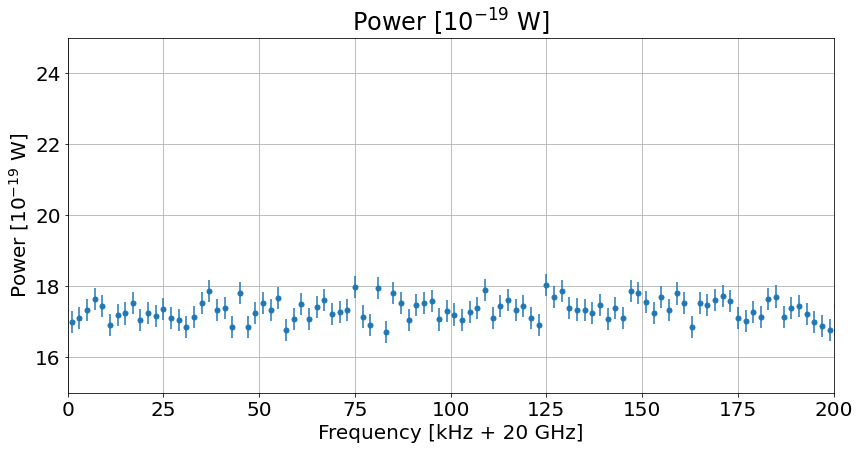

In [33]:
datadir1 =  "/data/ms2840a/result_data"
datadir2 =  "./output/result_data_newrebin1"

freq = 18.e+9
freq_offset = 18e+9
freq_conv = 1e-3
freq_label = 'Frequency [kHz + 20 GHz]'
W_conv = 1e+19
W_label = 'Power [$10^{-19}$ W]'

start, tmp, is_add_data = func.get_file_freq(freq)
add_dir = 'check_result/' if is_add_data else ''
path1 = f'{datadir1}/{add_dir}signal_12_data/start_{start}GHz.csv'
path2 = f'{datadir2}/{add_dir}signal_12_data/start_{start}GHz.csv'
print(path1)
print(path2)

data1 = func.csv_to_array(path1)
data2 = func.csv_to_array(path2)
_freq1 = data1['freq']
_freq2 = data2['freq']
keys = [ f'W_{i}' for i in range(12)]
_W1 = np.array([ data1[key] for key in keys ])
_W2 = np.array([ data2[key] for key in keys ])
print(keys)
print(data1.keys())
print(data2.keys())
_mean1 = np.mean(_W1, axis=0)
_mean2 = np.mean(_W2, axis=0)
print('_mean1', _mean1.shape)
print('_mean2', _mean2.shape)

print(np.diff(_freq1))
print(np.diff(_freq2))
freq1, W1, W_err1 = func.rebin_func_consider_rbw(_freq1, _mean1, method=1)
freq2, W2 = _freq2, _mean2
print(W1.shape)
print(W2.shape)

std1 = ( np.std(W1[:250]) + np.std(W1[-250:]) ) / 2.
std2 = ( np.std(W2[:250]) + np.std(W2[-250:]) ) / 2.
std1s = np.full(len(W1), std1)
std2s = np.full(len(W2), std2)
print(f"data1 (size={len(freq1)}): mean = {W1}, std = {std1}")
print(f"data2 (size={len(freq2)}): mean = {W2}, std = {std2}")

plt.rcParams["font.size"] = 20
fig, axes = plt.subplots(1,1,figsize=(12,6), squeeze=False, sharex=False)
fig.tight_layout()

ax=axes[0][0]
ax.errorbar((freq1-freq_offset)*freq_conv, W1*W_conv, std1s*W_conv, c='tab:blue', label='', ls='', marker='o', markersize=5)
ax.set_title(W_label)
ax.set_ylabel(W_label)
#ax.set_xlim(-0.25, 0.25)
ax.set_xlim(0, 200)
ax.set_ylim(15, 25)
ax.grid()
ax.set_xlabel(freq_label)